# Using SMAC to optimize hyperparameters of RF

* Installation of SMAC
* Defintion of function to be optimized (RF on Boston Dataset)
* Definition of RF's configspace
* Definition of SMAC's scenario
* Running SMAC

## Installation of SMAC and its Dependencies

In [56]:
!apt-get install swig -y
!pip install Cython
!pip install pyrfr==0.8.0 --no-cache --user
# hack to find pyrfr
import sys
import logging

sys.path.insert(0,"./.local/lib/python3.6/site-packages")

!pip install git+https://github.com/automl/SMAC3.git@development

logging.basicConfig(level=logging.INFO)

Reading package lists... Done
Building dependency tree       
Reading state information... Done
swig is already the newest version (3.0.10-1.2).
0 upgraded, 0 newly installed, 0 to remove and 0 not upgraded.
  Cloning https://github.com/automl/SMAC3.git (to revision development) to /tmp/pip-req-build-cgr1sqlg
  Running setup.py bdist_wheel for smac ... - \ done
  Stored in directory: /tmp/pip-ephem-wheel-cache-ws7enqxx/wheels/f4/8d/4f/2ba4cb80693f139ea06c2e8541e012a93738fb56bc1e43a202
Successfully built smac


## Installing Pep8

In [57]:
!pip install pycodestyle
!pip install pycodestyle_magic
%load_ext pycodestyle_magic

The pycodestyle_magic extension is already loaded. To reload it, use:
  %reload_ext pycodestyle_magic


## Optimize RF RMSE performance on Boston Dataset

In [0]:
# %%pycodestyle

from sklearn.metrics import make_scorer
from sklearn.cross_validation import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVC
from sklearn.datasets import load_iris
import numpy as np


iris = load_iris()


def rf_from_cfg(cfg, seed):
    """
        Creates a random forest regressor from sklearn and fits the given data on it.
        This is the function-call we try to optimize. Chosen values are stored in
        the configuration (cfg).

        Parameters:
        -----------
        cfg: Configuration
            configuration chosen by smac
        seed: int or RandomState
            used to initialize the rf's random generator

        Returns:
        -----------
        np.mean(rmses): float
            mean of root mean square errors of random-forest test predictions
            per cv-fold
    """
    # Following from the SMAC documentation example for SVM's

    # For deactivated parameters, the configuration stores None-values.
    # This is not accepted by the SVM, so we remove them.
    cfg = {k: cfg[k] for k in cfg if cfg[k]}

    # We translate boolean values:
    cfg["shrinking"] = True if cfg["shrinking"] == "true" else False

    clf = SVC(**cfg, random_state=42)

    scores = cross_val_score(clf, iris.data, iris.target, cv=5)
    return 1-np.mean(scores)  # Minimize!

## Define Configuration Space

In [59]:
# %%pycodestyle

from smac.configspace import ConfigurationSpace
from ConfigSpace.hyperparameters import CategoricalHyperparameter, \
    UniformFloatHyperparameter, UniformIntegerHyperparameter
from ConfigSpace.conditions import InCondition

cs = ConfigurationSpace()

c = UniformFloatHyperparameter("C", 0.001, 1000.0, default_value=1.0)
kernel = CategoricalHyperparameter("kernel", ["linear", "poly", "rbf", "sigmoid"], default_value="rbf")
shrinking = CategoricalHyperparameter("shrinking", ["true", "false"], default_value="true")
degree = UniformIntegerHyperparameter("degree", 1, 5, default_value=3)
coef0 = UniformFloatHyperparameter("coef0", 0.0, 10.0, default_value=0.0)
gamma = UniformFloatHyperparameter("gamma", 0.0001, 8.0, default_value=1.0)

con1 = InCondition(child=degree, parent=kernel, values=["poly"])
con2 = InCondition(child=gamma, parent=kernel, values=["poly", "rbf", "sigmoid"])
con3 = InCondition(child=coef0, parent=kernel, values=["poly", "sigmoid"])

cs.add_hyperparameters([c, kernel, shrinking, degree, coef0, gamma])
cs.add_conditions([con1, con2, con3])

print(cs)

Configuration space object:
  Hyperparameters:
    C, Type: UniformFloat, Range: [0.001, 1000.0], Default: 1.0
    coef0, Type: UniformFloat, Range: [0.0, 10.0], Default: 0.0
    degree, Type: UniformInteger, Range: [1, 5], Default: 3
    gamma, Type: UniformFloat, Range: [0.0001, 8.0], Default: 1.0
    kernel, Type: Categorical, Choices: {linear, poly, rbf, sigmoid}, Default: rbf
    shrinking, Type: Categorical, Choices: {true, false}, Default: true
  Conditions:
    coef0 | kernel in {'poly', 'sigmoid'}
    degree | kernel in {'poly'}
    gamma | kernel in {'poly', 'rbf', 'sigmoid'}



## Define Scenario

In [60]:
# %%pycodestyle

from smac.scenario.scenario import Scenario

scenario = Scenario({"run_obj": "quality",   # we optimize quality (alternative runtime)
                     "cs": cs,               # configuration space
                     "deterministic": "true",
                     "memory_limit": 3072,   # adapt this to reasonable value for your hardware
                     "output_dir": ".",       # deactivate output
                     "runcount_limit": 200,  # number of function evaluations
                     })

INFO:smac.utils.io.cmd_reader.CMDReader:Output to .


## Run SMAC

In [61]:
# %%pycodestyle

from smac.facade.smac_facade import SMAC

smac_list = []

run_smac_num = 10

for i in range(0, run_smac_num):
    smac = SMAC(scenario=scenario, rng=np.random.RandomState(42 + i),
                tae_runner=rf_from_cfg)

    incumbent = smac.optimize()
    smac_list.append(smac)

INFO:smac.facade.smac_facade.SMAC:Optimizing a deterministic scenario for quality without a tuner timeout - will make SMAC deterministic!
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0333
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0333
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0333
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0333
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0333
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0333
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0333
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.033

INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0333
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0333
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0333
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0333
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0333
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0333
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0333
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0333
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0333
INFO:smac.intensification.in

INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0333
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0333
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0333
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0333
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0333
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0333
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0333
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0333
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0333
INFO:smac.intensification.in

INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0333
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0333
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0333
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0333
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0333
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0333
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0333
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0333
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0333
INFO:smac.intensification.in

INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0333
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0333
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0333
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0333
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0333
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0333
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0333
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0333
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0333
INFO:smac.intensification.in

INFO:smac.stats.stats.Stats:#Incumbent changed: 0
INFO:smac.stats.stats.Stats:#Target algorithm runs: 200 / 200.0
INFO:smac.stats.stats.Stats:#Configurations: 199
INFO:smac.stats.stats.Stats:Used wallclock time: 115.42 / inf sec 
INFO:smac.stats.stats.Stats:Used target algorithm runtime: 20.49 / inf sec
INFO:smac.stats.stats.Stats:##########################################################
INFO:smac.facade.smac_facade.SMAC:Final Incumbent: Configuration:
  C, Value: 1.0
  gamma, Value: 1.0
  kernel, Value: 'rbf'
  shrinking, Value: 'true'

INFO:smac.facade.smac_facade.SMAC:Estimated cost of incumbent: 0.033333
INFO:smac.facade.smac_facade.SMAC:Optimizing a deterministic scenario for quality without a tuner timeout - will make SMAC deterministic!
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0333
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0333
INFO:smac.intensification.int

INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0267
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0267
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0267
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0267
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0267
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0267
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0267
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0267
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0267
INFO:smac.intensification.in

INFO:smac.intensification.intensification.Intensifier:  gamma : 0.06768134446447766 -> 0.018911490559397236
INFO:smac.intensification.intensification.Intensifier:  kernel : 'poly' -> 'rbf'
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0133
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0133
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0133
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0133
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0133
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0133
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0133
INFO:smac.intensification.intensification.Intensifier:U

INFO:smac.stats.stats.Stats:Statistics:
INFO:smac.stats.stats.Stats:#Incumbent changed: 3
INFO:smac.stats.stats.Stats:#Target algorithm runs: 200 / 200.0
INFO:smac.stats.stats.Stats:#Configurations: 199
INFO:smac.stats.stats.Stats:Used wallclock time: 108.37 / inf sec 
INFO:smac.stats.stats.Stats:Used target algorithm runtime: 17.48 / inf sec
INFO:smac.stats.stats.Stats:##########################################################
INFO:smac.facade.smac_facade.SMAC:Final Incumbent: Configuration:
  C, Value: 24.036691618788257
  gamma, Value: 0.018911490559397236
  kernel, Value: 'rbf'
  shrinking, Value: 'true'

INFO:smac.facade.smac_facade.SMAC:Estimated cost of incumbent: 0.013333
INFO:smac.facade.smac_facade.SMAC:Optimizing a deterministic scenario for quality without a tuner timeout - will make SMAC deterministic!
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0333
INFO:smac.intensification.intensification.Intensifier:Updated est

INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0333
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0333
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0333
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0333
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0333
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0333
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0333
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0333
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0333
INFO:smac.intensification.in

INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0267
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0267
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0267
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0267
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0267
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0267
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0267
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0267
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0267
INFO:smac.intensification.in

INFO:smac.stats.stats.Stats:Used wallclock time: 108.54 / inf sec 
INFO:smac.stats.stats.Stats:Used target algorithm runtime: 19.47 / inf sec
INFO:smac.stats.stats.Stats:##########################################################
INFO:smac.facade.smac_facade.SMAC:Final Incumbent: Configuration:
  C, Value: 1.0
  coef0, Value: 0.0
  degree, Value: 1
  gamma, Value: 0.6953651947408722
  kernel, Value: 'poly'
  shrinking, Value: 'false'

INFO:smac.facade.smac_facade.SMAC:Estimated cost of incumbent: 0.013333
INFO:smac.facade.smac_facade.SMAC:Optimizing a deterministic scenario for quality without a tuner timeout - will make SMAC deterministic!
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0333
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0333
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0333
INFO:smac.intensification.in

INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0333
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0333
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0333
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0333
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0333
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0333
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0333
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0333
INFO:smac.intensification.intensification.Intensifier:Challenger (0.0267) is better than incumbent (0.0333) on 1 runs.
INFO:smac.intensi

INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0267
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0267
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0267
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0267
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0267
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0267
INFO:smac.intensification.intensification.Intensifier:Challenger (0.0200) is better than incumbent (0.0267) on 1 runs.
INFO:smac.intensification.intensification.Intensifier:Changes in incumbent:
INFO:smac.intensification.intensification.Intensifier:  C : 43.64248180768551 -> 22.408630074217882
INFO:smac.intensification.intensification.Intensifier:  c

INFO:smac.stats.stats.Stats:#Configurations: 199
INFO:smac.stats.stats.Stats:Used wallclock time: 116.11 / inf sec 
INFO:smac.stats.stats.Stats:Used target algorithm runtime: 16.27 / inf sec
INFO:smac.stats.stats.Stats:##########################################################
INFO:smac.facade.smac_facade.SMAC:Final Incumbent: Configuration:
  C, Value: 13.481529513888741
  coef0, Value: 1.2024699078140195
  degree, Value: 1
  gamma, Value: 0.05073050904268266
  kernel, Value: 'poly'
  shrinking, Value: 'false'

INFO:smac.facade.smac_facade.SMAC:Estimated cost of incumbent: 0.013333
INFO:smac.facade.smac_facade.SMAC:Optimizing a deterministic scenario for quality without a tuner timeout - will make SMAC deterministic!
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0333
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0333
INFO:smac.intensification.intensification.Intensifier:Up

INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0200
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0200
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0200
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0200
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0200
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0200
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0200
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0200
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0200
INFO:smac.intensification.in

INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0133
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0133
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0133
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0133
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0133
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0133
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0133
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0133
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0133
INFO:smac.intensification.in

INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0333
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0333
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0333
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0333
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0333
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0333
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0333
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0333
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0333
INFO:smac.intensification.in

INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0133
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0133
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0133
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0133
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0133
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0133
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0133
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0133
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0133
INFO:smac.intensification.in

INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0133
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0133
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0133
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0133
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0133
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0133
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0133
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0133
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0133
INFO:smac.intensification.in

INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0333
INFO:smac.intensification.intensification.Intensifier:Challenger (0.0200) is better than incumbent (0.0333) on 1 runs.
INFO:smac.intensification.intensification.Intensifier:Changes in incumbent:
INFO:smac.intensification.intensification.Intensifier:  C : 1.0 -> 860.1650756311233
INFO:smac.intensification.intensification.Intensifier:  coef0 : None -> 2.997152829606635
INFO:smac.intensification.intensification.Intensifier:  degree : None -> 1
INFO:smac.intensification.intensification.Intensifier:  gamma : 1.0 -> 0.0026111795737503514
INFO:smac.intensification.intensification.Intensifier:  kernel : 'rbf' -> 'poly'
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0200
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0200
INFO:smac.intensification.intensification.Intensifier:Upd

INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0200
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0200
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0200
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0200
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0200
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0200
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0200
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0200
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0200
INFO:smac.intensification.in

INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0133
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0133
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0133
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0133
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0133
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0133
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0133
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0133
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0133
INFO:smac.intensification.in

INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0333
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0333
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0333
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0333
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0333
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0333
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0333
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0333
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0333
INFO:smac.intensification.in

INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0333
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0333
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0333
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0333
INFO:smac.intensification.intensification.Intensifier:Challenger (0.0267) is better than incumbent (0.0333) on 1 runs.
INFO:smac.intensification.intensification.Intensifier:Changes in incumbent:
INFO:smac.intensification.intensification.Intensifier:  C : 1.0 -> 927.1608793189739
INFO:smac.intensification.intensification.Intensifier:  coef0 : None -> 0.28801850279502106
INFO:smac.intensification.intensification.Intensifier:  degree : None -> 1
INFO:smac.intensification.intensification.Intensifier:  gamma : 1.0 -> 0.009377296363898736
INFO:smac.intensification.int

INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0267
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0267
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0267
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0267
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0267
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0267
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0267
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0267
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0267
INFO:smac.intensification.in

INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0333
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0333
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0333
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0333
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0333
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0333
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0333
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0333
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0333
INFO:smac.intensification.in

INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0200
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0200
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0200
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0200
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0200
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0200
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0200
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0200
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0200
INFO:smac.intensification.in

INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0133
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0133
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0133
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0133
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0133
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0133
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0133
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0133
INFO:smac.stats.stats.Stats:##########################################################
INFO:smac.stats.stats.Stats:Statistics:
INFO:smac

### Get Data

In [0]:
# %%pycodestyle

def get_data(smac):

    data = []

    for element in smac:
        # get runhistory, all runs ever evaluated by smac
        runhistory = element.get_runhistory()

        # extract x value and corresponding y value
        x_smac = []
        y_smac = []
        for entry in runhistory.data:  # iterate over data because it is an OrderedDict
            config_id = entry.config_id  # look up config id
            config = runhistory.ids_config[config_id]  # look up config
            y_ = runhistory.get_cost(config)  # get cost
            x_ = config["x1"]  # there is only one entry in our example
            x_smac.append(x_)
            y_smac.append(y_)
        x_smac = np.array(x_smac)
        y_smac = np.array(y_smac)
        data.append(y_smac)
    return data

## CV with instances

In [0]:
# %%pycodestyle

fold  = 0
def rf_from_cfg_inst(cfg, seed):
    """
        Creates a random forest regressor from sklearn and fits the given data on it.
        This is the function-call we try to optimize. Chosen values are stored in
        the configuration (cfg).

        Parameters:
        -----------
        cfg: Configuration
            configuration chosen by smac
        seed: int or RandomState
            used to initialize the rf's random generator

        Returns:
        -----------
        np.mean(rmses): float
            mean of root mean square errors of random-forest test predictions
            per cv-fold
    """
    # Following from the SMAC documentation example for SVM's

    # For deactivated parameters, the configuration stores None-values.
    # This is not accepted by the SVM, so we remove them.
    cfg = {k: cfg[k] for k in cfg if cfg[k]}

    # We translate boolean values:
    cfg["shrinking"] = True if cfg["shrinking"] == "true" else False

    clf = SVC(**cfg, random_state=42)
    scores = cross_val_score(clf, iris.data, iris.target, cv=5)
    return 1-scores[fold]  # Minimize!

## Scenario with instances

In [64]:
# %%pycodestyle

from smac.scenario.scenario import Scenario

scenario_i = Scenario({"run_obj": "quality",   # we optimize quality (alternative runtime)
                     "cs": cs,               # configuration space
                     "deterministic": "true",
                     "memory_limit": 3072,   # adapt this to reasonable value for your hardware
                     "output_dir": ".",       # deactivate output
                     "runcount_limit": 40,  # number of function evaluations
                     })

INFO:smac.utils.io.cmd_reader.CMDReader:Output to .


## Run SMAC with instances

In [65]:
# %%pycodestyle



smac_list_i = []

run_smac_num = 10

for i in range(0, run_smac_num):
    fold = 0
    for j in range(5):
      fold = j
      smac_i = SMAC(scenario=scenario_i, rng=np.random.RandomState(42 + i),
                  tae_runner=rf_from_cfg_inst)

      incumbent = smac_i.optimize()
      smac_list_i.append(smac_i)

INFO:smac.facade.smac_facade.SMAC:Optimizing a deterministic scenario for quality without a tuner timeout - will make SMAC deterministic!
INFO:smac.intensification.intensification.Intensifier:Challenger (0.0000) is better than incumbent (0.0333) on 1 runs.
INFO:smac.intensification.intensification.Intensifier:Changes in incumbent:
INFO:smac.intensification.intensification.Intensifier:  C : 1.0 -> 947.1085402114472
INFO:smac.intensification.intensification.Intensifier:  kernel : 'rbf' -> 'linear'
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0000
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0000
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0000
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0000
INFO:smac.intensification.intensification.Intensifier:Updated estim

INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0000
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0000
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0000
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0000
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0000
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0000
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0000
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0000
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0000
INFO:smac.intensification.in

INFO:smac.stats.stats.Stats:#Configurations: 39
INFO:smac.stats.stats.Stats:Used wallclock time: 22.15 / inf sec 
INFO:smac.stats.stats.Stats:Used target algorithm runtime: 4.26 / inf sec
INFO:smac.stats.stats.Stats:##########################################################
INFO:smac.facade.smac_facade.SMAC:Final Incumbent: Configuration:
  C, Value: 1.0
  gamma, Value: 1.0
  kernel, Value: 'rbf'
  shrinking, Value: 'true'

INFO:smac.facade.smac_facade.SMAC:Estimated cost of incumbent: 0.100000
INFO:smac.facade.smac_facade.SMAC:Optimizing a deterministic scenario for quality without a tuner timeout - will make SMAC deterministic!
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0333
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0333
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0333
INFO:smac.intensification.intensificat

INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0000
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0000
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0000
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0000
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0000
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0000
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0000
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0000
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0000
INFO:smac.intensification.in

INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0000
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0000
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0000
INFO:smac.stats.stats.Stats:##########################################################
INFO:smac.stats.stats.Stats:Statistics:
INFO:smac.stats.stats.Stats:#Incumbent changed: 1
INFO:smac.stats.stats.Stats:#Target algorithm runs: 40 / 40.0
INFO:smac.stats.stats.Stats:#Configurations: 39
INFO:smac.stats.stats.Stats:Used wallclock time: 17.91 / inf sec 
INFO:smac.stats.stats.Stats:Used target algorithm runtime: 3.79 / inf sec
INFO:smac.stats.stats.Stats:##########################################################
INFO:smac.facade.smac_facade.SMAC:Final Incumbent: Configuration:
  C, Value: 755.9527278976885
  gamma, Value: 6.406821611596438
  kernel, Value: 'rbf'
  shrinki

INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.1000
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.1000
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.1000
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.1000
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.1000
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.1000
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.1000
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.1000
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.1000
INFO:smac.intensification.in

INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0333
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0333
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0333
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0333
INFO:smac.stats.stats.Stats:##########################################################
INFO:smac.stats.stats.Stats:Statistics:
INFO:smac.stats.stats.Stats:#Incumbent changed: 0
INFO:smac.stats.stats.Stats:#Target algorithm runs: 40 / 40.0
INFO:smac.stats.stats.Stats:#Configurations: 39
INFO:smac.stats.stats.Stats:Used wallclock time: 18.95 / inf sec 
INFO:smac.stats.stats.Stats:Used target algorithm runtime: 4.31 / inf sec
INFO:smac.stats.stats.Stats:##########################################################
INFO:smac.facade.smac_facade.SMAC:Final Incumbent: Con

INFO:smac.intensification.intensification.Intensifier:Challenger (0.0000) is better than incumbent (0.0333) on 1 runs.
INFO:smac.intensification.intensification.Intensifier:Changes in incumbent:
INFO:smac.intensification.intensification.Intensifier:  C : 1.0 -> 339.4920457556261
INFO:smac.intensification.intensification.Intensifier:  kernel : 'rbf' -> 'linear'
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0000
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0000
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0000
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0000
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0000
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 ru

INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0000
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0000
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0000
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0000
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0000
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0000
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0000
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0000
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0000
INFO:smac.stats.stats.Stats:

INFO:smac.stats.stats.Stats:Used wallclock time: 19.61 / inf sec 
INFO:smac.stats.stats.Stats:Used target algorithm runtime: 3.92 / inf sec
INFO:smac.stats.stats.Stats:##########################################################
INFO:smac.facade.smac_facade.SMAC:Final Incumbent: Configuration:
  C, Value: 1.0
  gamma, Value: 1.0
  kernel, Value: 'rbf'
  shrinking, Value: 'true'

INFO:smac.facade.smac_facade.SMAC:Estimated cost of incumbent: 0.100000
INFO:smac.facade.smac_facade.SMAC:Optimizing a deterministic scenario for quality without a tuner timeout - will make SMAC deterministic!
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0333
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0333
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0333
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumb

INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0000
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0000
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0000
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0000
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0000
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0000
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0000
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0000
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0000
INFO:smac.intensification.in

INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0000
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0000
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0000
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0000
INFO:smac.stats.stats.Stats:##########################################################
INFO:smac.stats.stats.Stats:Statistics:
INFO:smac.stats.stats.Stats:#Incumbent changed: 1
INFO:smac.stats.stats.Stats:#Target algorithm runs: 40 / 40.0
INFO:smac.stats.stats.Stats:#Configurations: 39
INFO:smac.stats.stats.Stats:Used wallclock time: 20.36 / inf sec 
INFO:smac.stats.stats.Stats:Used target algorithm runtime: 4.94 / inf sec
INFO:smac.stats.stats.Stats:##########################################################
INFO:smac.facade.smac_facade.SMAC:Final Incumbent: Con

INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.1000
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.1000
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.1000
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.1000
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.1000
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.1000
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.1000
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.1000
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.1000
INFO:smac.intensification.in

INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0333
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0333
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0333
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0333
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0333
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0333
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0333
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0333
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0333
INFO:smac.stats.stats.Stats:

INFO:smac.stats.stats.Stats:Used wallclock time: 17.68 / inf sec 
INFO:smac.stats.stats.Stats:Used target algorithm runtime: 2.40 / inf sec
INFO:smac.stats.stats.Stats:##########################################################
INFO:smac.facade.smac_facade.SMAC:Final Incumbent: Configuration:
  C, Value: 1.0
  gamma, Value: 1.0
  kernel, Value: 'rbf'
  shrinking, Value: 'true'

INFO:smac.facade.smac_facade.SMAC:Estimated cost of incumbent: 0.000000
INFO:smac.facade.smac_facade.SMAC:Optimizing a deterministic scenario for quality without a tuner timeout - will make SMAC deterministic!
INFO:smac.intensification.intensification.Intensifier:Challenger (0.0000) is better than incumbent (0.0333) on 1 runs.
INFO:smac.intensification.intensification.Intensifier:Changes in incumbent:
INFO:smac.intensification.intensification.Intensifier:  C : 1.0 -> 290.77021780934473
INFO:smac.intensification.intensification.Intensifier:  coef0 : None -> 9.91678021237001
INFO:smac.intensification.intensificatio

INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0000
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0000
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0000
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0000
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0000
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0000
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0000
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0000
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0000
INFO:smac.intensification.in

INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.1000
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.1000
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.1000
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.1000
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.1000
INFO:smac.stats.stats.Stats:##########################################################
INFO:smac.stats.stats.Stats:Statistics:
INFO:smac.stats.stats.Stats:#Incumbent changed: 0
INFO:smac.stats.stats.Stats:#Target algorithm runs: 40 / 40.0
INFO:smac.stats.stats.Stats:#Configurations: 39
INFO:smac.stats.stats.Stats:Used wallclock time: 23.14 / inf sec 
INFO:smac.stats.stats.Stats:Used target algorithm runtime: 5.93 / inf sec
INFO:smac.stats.stats.Stats:#####

INFO:smac.facade.smac_facade.SMAC:Optimizing a deterministic scenario for quality without a tuner timeout - will make SMAC deterministic!
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0000
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0000
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0000
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0000
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0000
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0000
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0000
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.000

INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0000
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0000
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0000
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0000
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0000
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0000
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0000
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0000
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0000
INFO:smac.intensification.in

INFO:smac.stats.stats.Stats:#Incumbent changed: 0
INFO:smac.stats.stats.Stats:#Target algorithm runs: 40 / 40.0
INFO:smac.stats.stats.Stats:#Configurations: 39
INFO:smac.stats.stats.Stats:Used wallclock time: 20.37 / inf sec 
INFO:smac.stats.stats.Stats:Used target algorithm runtime: 3.76 / inf sec
INFO:smac.stats.stats.Stats:##########################################################
INFO:smac.facade.smac_facade.SMAC:Final Incumbent: Configuration:
  C, Value: 1.0
  gamma, Value: 1.0
  kernel, Value: 'rbf'
  shrinking, Value: 'true'

INFO:smac.facade.smac_facade.SMAC:Estimated cost of incumbent: 0.000000
INFO:smac.facade.smac_facade.SMAC:Optimizing a deterministic scenario for quality without a tuner timeout - will make SMAC deterministic!
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.1000
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.1000
INFO:smac.intensification.intensif

INFO:smac.facade.smac_facade.SMAC:Estimated cost of incumbent: 0.000000
INFO:smac.facade.smac_facade.SMAC:Optimizing a deterministic scenario for quality without a tuner timeout - will make SMAC deterministic!
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0333
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0333
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0333
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0333
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0333
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0333
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0333
INFO:smac.intensification.intensif

INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0000
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0000
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0000
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0000
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0000
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0000
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0000
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0000
INFO:smac.stats.stats.Stats:##########################################################
INFO:smac.stats.stats.Stats:Statistics:
INFO:smac

INFO:smac.stats.stats.Stats:##########################################################
INFO:smac.stats.stats.Stats:Statistics:
INFO:smac.stats.stats.Stats:#Incumbent changed: 1
INFO:smac.stats.stats.Stats:#Target algorithm runs: 40 / 40.0
INFO:smac.stats.stats.Stats:#Configurations: 39
INFO:smac.stats.stats.Stats:Used wallclock time: 19.92 / inf sec 
INFO:smac.stats.stats.Stats:Used target algorithm runtime: 4.66 / inf sec
INFO:smac.stats.stats.Stats:##########################################################
INFO:smac.facade.smac_facade.SMAC:Final Incumbent: Configuration:
  C, Value: 581.4954502517313
  coef0, Value: 3.9837625051488565
  degree, Value: 1
  gamma, Value: 7.00630039587532
  kernel, Value: 'poly'
  shrinking, Value: 'true'

INFO:smac.facade.smac_facade.SMAC:Estimated cost of incumbent: 0.000000
INFO:smac.facade.smac_facade.SMAC:Optimizing a deterministic scenario for quality without a tuner timeout - will make SMAC deterministic!
INFO:smac.intensification.intensification

INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.1000
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.1000
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.1000
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.1000
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.1000
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.1000
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.1000
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.1000
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.1000
INFO:smac.intensification.in

INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0333
INFO:smac.stats.stats.Stats:##########################################################
INFO:smac.stats.stats.Stats:Statistics:
INFO:smac.stats.stats.Stats:#Incumbent changed: 0
INFO:smac.stats.stats.Stats:#Target algorithm runs: 40 / 40.0
INFO:smac.stats.stats.Stats:#Configurations: 39
INFO:smac.stats.stats.Stats:Used wallclock time: 16.88 / inf sec 
INFO:smac.stats.stats.Stats:Used target algorithm runtime: 3.48 / inf sec
INFO:smac.stats.stats.Stats:##########################################################
INFO:smac.facade.smac_facade.SMAC:Final Incumbent: Configuration:
  C, Value: 1.0
  gamma, Value: 1.0
  kernel, Value: 'rbf'
  shrinking, Value: 'true'

INFO:smac.facade.smac_facade.SMAC:Estimated cost of incumbent: 0.033333
INFO:smac.facade.smac_facade.SMAC:Optimizing a deterministic scenario for quality without a tuner timeout - will make SMAC deterministic!
INFO:smac.inten

INFO:smac.intensification.intensification.Intensifier:  shrinking : 'true' -> 'false'
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0000
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0000
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0000
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0000
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0000
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0000
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0000
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0000
INFO:smac.intensification.intensification.Intensif

INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0000
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0000
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0000
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0000
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0000
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0000
INFO:smac.stats.stats.Stats:##########################################################
INFO:smac.stats.stats.Stats:Statistics:
INFO:smac.stats.stats.Stats:#Incumbent changed: 0
INFO:smac.stats.stats.Stats:#Target algorithm runs: 40 / 40.0
INFO:smac.stats.stats.Stats:#Configurations: 39
INFO:smac.stats.stats.Stats:Used wallclock time: 19.49 / inf sec 

INFO:smac.stats.stats.Stats:#Incumbent changed: 1
INFO:smac.stats.stats.Stats:#Target algorithm runs: 40 / 40.0
INFO:smac.stats.stats.Stats:#Configurations: 39
INFO:smac.stats.stats.Stats:Used wallclock time: 20.68 / inf sec 
INFO:smac.stats.stats.Stats:Used target algorithm runtime: 2.64 / inf sec
INFO:smac.stats.stats.Stats:##########################################################
INFO:smac.facade.smac_facade.SMAC:Final Incumbent: Configuration:
  C, Value: 860.1650756311233
  coef0, Value: 2.997152829606635
  degree, Value: 1
  gamma, Value: 0.0026111795737503514
  kernel, Value: 'poly'
  shrinking, Value: 'true'

INFO:smac.facade.smac_facade.SMAC:Estimated cost of incumbent: 0.033333
INFO:smac.facade.smac_facade.SMAC:Optimizing a deterministic scenario for quality without a tuner timeout - will make SMAC deterministic!
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0333
INFO:smac.intensification.intensification.Intensifier:Up

INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0000
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0000
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0000
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0000
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0000
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0000
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0000
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0000
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0000
INFO:smac.intensification.in

INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0000
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0000
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0000
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0000
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0000
INFO:smac.stats.stats.Stats:##########################################################
INFO:smac.stats.stats.Stats:Statistics:
INFO:smac.stats.stats.Stats:#Incumbent changed: 1
INFO:smac.stats.stats.Stats:#Target algorithm runs: 40 / 40.0
INFO:smac.stats.stats.Stats:#Configurations: 39
INFO:smac.stats.stats.Stats:Used wallclock time: 17.95 / inf sec 
INFO:smac.stats.stats.Stats:Used target algorithm runtime: 4.45 / inf sec
INFO:smac.stats.stats.Stats:#####

INFO:smac.facade.smac_facade.SMAC:Optimizing a deterministic scenario for quality without a tuner timeout - will make SMAC deterministic!
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.1000
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.1000
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.1000
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.1000
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.1000
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.1000
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.1000
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.100

INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0333
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0333
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0333
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0333
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0333
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0333
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0333
INFO:smac.stats.stats.Stats:##########################################################
INFO:smac.stats.stats.Stats:Statistics:
INFO:smac.stats.stats.Stats:#Incumbent changed: 0
INFO:smac.stats.stats.Stats:#Target algorithm runs: 40 / 40.0
INFO:

INFO:smac.facade.smac_facade.SMAC:Final Incumbent: Configuration:
  C, Value: 1.0
  gamma, Value: 1.0
  kernel, Value: 'rbf'
  shrinking, Value: 'true'

INFO:smac.facade.smac_facade.SMAC:Estimated cost of incumbent: 0.000000
INFO:smac.facade.smac_facade.SMAC:Optimizing a deterministic scenario for quality without a tuner timeout - will make SMAC deterministic!
INFO:smac.intensification.intensification.Intensifier:Challenger (0.0000) is better than incumbent (0.0333) on 1 runs.
INFO:smac.intensification.intensification.Intensifier:Changes in incumbent:
INFO:smac.intensification.intensification.Intensifier:  C : 1.0 -> 654.9903182400845
INFO:smac.intensification.intensification.Intensifier:  coef0 : None -> 7.201288908057547
INFO:smac.intensification.intensification.Intensifier:  degree : None -> 1
INFO:smac.intensification.intensification.Intensifier:  gamma : 1.0 -> 3.386587757615192
INFO:smac.intensification.intensification.Intensifier:  kernel : 'rbf' -> 'poly'
INFO:smac.intensificat

INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0000
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0000
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0000
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0000
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0000
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0000
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0000
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0000
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0000
INFO:smac.intensification.in

INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.1000
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.1000
INFO:smac.stats.stats.Stats:##########################################################
INFO:smac.stats.stats.Stats:Statistics:
INFO:smac.stats.stats.Stats:#Incumbent changed: 0
INFO:smac.stats.stats.Stats:#Target algorithm runs: 40 / 40.0
INFO:smac.stats.stats.Stats:#Configurations: 39
INFO:smac.stats.stats.Stats:Used wallclock time: 21.16 / inf sec 
INFO:smac.stats.stats.Stats:Used target algorithm runtime: 4.46 / inf sec
INFO:smac.stats.stats.Stats:##########################################################
INFO:smac.facade.smac_facade.SMAC:Final Incumbent: Configuration:
  C, Value: 1.0
  gamma, Value: 1.0
  kernel, Value: 'rbf'
  shrinking, Value: 'true'

INFO:smac.facade.smac_facade.SMAC:Estimated cost of incumbent: 0.100000
INFO:smac.facade.smac_facade.SMAC:Optimizing 

INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0000
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0000
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0000
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0000
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0000
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0000
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0000
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0000
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0000
INFO:smac.intensification.in

### Plot function

In [0]:
# %%pycodestyle

from matplotlib import mlab
from matplotlib import pyplot as plt


def plot_performance(smac_list, MAX_FUN, fig, color, color_face):

    median2, median2_i = [], []
    first_quartel, first_quartel_i = [], []
    second_quartel, second_quartel_i = [], []
    data = get_data(smac_list)
    
    data_i = get_data(smac_list_i)
    tmp_data = []
    tmp = []
    for k in range(len(data_i)):
      tmp.extend(data_i[k])
      if k % 5 == 4:
        tmp_data.append(tmp)
        tmp = []
        
    data_i = tmp_data
   

    med_of_eval, med_of_eval_i = [], []

    for j in range(0, MAX_FUN):

        for i in range(0, len(data)):
            med_of_eval.append(data[i][j])
            
        for i in range(0, len(data_i)):
            med_of_eval_i.append(data_i[i][j])
            

        med_of_eval.sort()
        a, b, c = mlab.prctile(med_of_eval, p=(25.0, 50.0, 75.0))
        median2.append(b)
        first_quartel.append(a)
        second_quartel.append(c)
        
        med_of_eval_i.sort()
        a, b, c = mlab.prctile(med_of_eval_i, p=(25.0, 50.0, 75.0))
        median2_i.append(b)
        first_quartel_i.append(a)
        second_quartel_i.append(c)

    # print(first_quartel)
    # print(median2)
    # print(second_quartel)

    ax = fig.add_subplot(111)

    # Plotting
    ax.step(median2_i, 'ro', where='post', label='with instances')
    ax.fill_between (range(MAX_FUN), first_quartel_i, second_quartel_i, alpha=0.5, color='r')
    ax.step(median2, 'bo', where='post', label='without instances')
    ax.fill_between (range(MAX_FUN), first_quartel, second_quartel, alpha=0.5)
    ax.legend(loc = 'upper right')
    ax.set_xscale('log')
    plt.title('With or without instances')
   

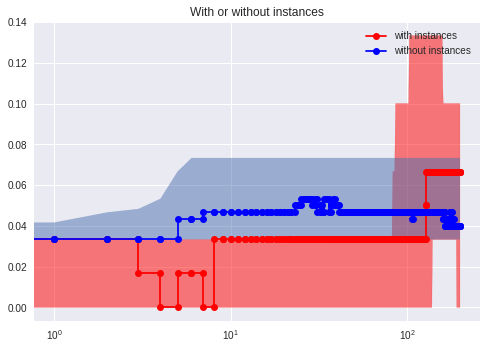

In [67]:
# %%pycodestyle

fig = plt.figure()
plot_performance(smac_list, 200, fig, 'cornflowerblue', 'lightskyblue')